In [1]:
import os
import torch
import random
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.sparse import coo_matrix
from torch.utils.data import random_split
from sklearn.metrics import confusion_matrix
from torch_geometric.data import Data, DataLoader
from torch_geometric.loader import DataLoader as GeoDataLoader
from sklearn.utils.class_weight import compute_class_weight

from model import *
from utils import *

device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f'Using device: {device}')

Using device: mps


## Count images without adjacencies

In [2]:
def count_valid_files(directory):
    return sum(1 for filename in os.listdir(directory) if not filename.startswith('.') and os.path.isfile(os.path.join(directory, filename)))

image_data_dir = './DATASET/train'
image_lengths = {subdir: count_valid_files(os.path.join(image_data_dir, subdir)) for subdir in os.listdir(image_data_dir) if not subdir.startswith('.') and os.path.isdir(os.path.join(image_data_dir, subdir))}

adjacency_dir = './output_data/adjacency_kenny'
adjacency_lengths = {subdir: count_valid_files(os.path.join(adjacency_dir, subdir)) for subdir in os.listdir(adjacency_dir) if not subdir.startswith('.') and os.path.isdir(os.path.join(adjacency_dir, subdir))}

print("Image data lengths:")
print(image_lengths)

print("Adjacency data lengths:")
print(adjacency_lengths)

Image data lengths:
{'7': 2524, '6': 705, '1': 1290, '4': 4772, '3': 717, '2': 281, '5': 1982}
Adjacency data lengths:
{'adjacency_2': 241, 'adjacency_5': 664, 'adjacency_4': 1915, 'adjacency_3': 256, 'adjacency_6': 524, 'adjacency_1': 1165, 'adjacency_7': 2127}


## label setting

In [3]:
# Set directory paths
dir_1 = './output_data/adjacency_kenny/adjacency_1'
dir_2 = './output_data/adjacency_kenny/adjacency_2'
dir_3 = './output_data/adjacency_kenny/adjacency_3'
dir_4 = './output_data/adjacency_kenny/adjacency_4'
dir_5 = './output_data/adjacency_kenny/adjacency_5'
dir_6 = './output_data/adjacency_kenny/adjacency_6'
dir_7 = './output_data/adjacency_kenny/adjacency_7'

image_dir = './DATASET/train'

dir_label_map = {
    '1': (dir_1, 0),
    '2': (dir_2, 1),
    '3': (dir_3, 2),
    '4': (dir_4, 3),
    '5': (dir_5, 4),
    '6': (dir_6, 5),
    '7': (dir_7, 6),
}

data_dict = {str(i): [] for i in range(1, 8)}
num_node_features = 21

def process_files(directory, label, image_dir, data_dict, key):
    adjacency_files = set(f.replace('adjacency_matrix_', '').replace('.jpg.csv', '') for f in os.listdir(directory) if f.endswith('.csv'))
    image_files = set(f.replace('.jpg', '') for f in os.listdir(os.path.join(image_dir, key)) if f.endswith('.jpg'))

    # Image with no adj unique_id
    missing_adj = image_files - adjacency_files
    
    for unique_id in image_files:
        image_path = os.path.join(image_dir, key, f'{unique_id}.jpg')
        file_path = os.path.join(directory, f'adjacency_matrix_{unique_id}.jpg.csv')

        if unique_id in missing_adj:
            # No adj, use CNN only
            image_data = process_image(image_path)
            
            # for handling model error
            placeholder_x = torch.zeros(1, num_node_features)
            placeholder_index = torch.empty((2, 0), dtype=torch.long)
            placeholder_weight = torch.empty((0,), dtype=torch.float)
            
            data = Data(x=placeholder_x, edge_index=placeholder_index, edge_weight=placeholder_weight, image_features=image_data)
            data.y = torch.tensor([label])
            data_dict[key].append(data)
            
        elif os.path.exists(file_path) and os.path.exists(image_path):
            # Image with adjacency matrix
            data = process_adj_matrix(file_path, image_path)
            data.y = torch.tensor([label])
            data_dict[key].append(data)
            
        else:
            print(f"Unexpected missing file for {unique_id}")
            
for key, (directory, label) in dir_label_map.items():
    process_files(directory, label, image_dir, data_dict, key)

In [4]:
print("Image data lengths:")
print(image_lengths)
print("Processed data")
print([len(data_dict[f'{i}']) for i in range(1, 8)])

Image data lengths:
{'7': 2524, '6': 705, '1': 1290, '4': 4772, '3': 717, '2': 281, '5': 1982}
Processed data
[1290, 281, 717, 4772, 1982, 705, 2524]


## Test the model propogationdata_dict

In [5]:
# Without adj data

edge_weight = torch.empty(0)
edge_index = torch.empty(2, 0, dtype=torch.long)

if edge_index is not None and edge_weight is not None and edge_weight.numel() > 0:
    # GCN component
    print('not empty')
else:
    print('empty')

# with adj data

edge_weight = data_dict['1'][0].edge_weight
edge_index = data_dict['1'][0].edge_index
if edge_index is not None and edge_weight is not None and edge_weight.numel() > 0:
    # GCN component
    print('not empty')
else:
    print('empty')

empty
not empty


In [6]:
data_list = data_dict['1'] + data_dict['2'] + data_dict['3'] + data_dict['4'] + data_dict['5'] + data_dict['6'] + data_dict['7']

batch_size = 64

total_size = len(data_list)
train_size = int(0.8 * total_size)
val_size = total_size - train_size

train_data, val_data = random_split(data_list, [train_size, val_size])

# Step 2: Create DataLoader for training and validation
train_loader = GeoDataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = GeoDataLoader(val_data, batch_size=batch_size, shuffle=False)

# Step 3: Model setup
# Some of the datas don't have adj matrix
num_node_features = next(data.x.shape[1] for data in data_list if data.x is not None)

hidden_channels = 64

labels = [data.y.item() for data in data_list]  # 提取所有樣本的標籤
class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

model = Net_Alex(num_node_features, hidden_channels).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 25

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
# Initialize variables for cumulative predictions and labels
cumulative_preds = []
cumulative_labels = []

for epoch in range(1, num_epochs + 1):
    # Initialize epoch tracking variables
    model.train()
    total_loss = 0
    correct = 0

    # Training phase
    for batch in train_loader:
        batch = batch.to(device)

        x = batch.x
        edge_index = batch.edge_index
        edge_weight = batch.edge_weight
        image_features = batch.image_features
        batch_y = batch.y

        optimizer.zero_grad()
        
        out = model(x, edge_index, edge_weight, batch.batch, image_features)
        loss = criterion(out, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        _, pred = out.max(dim=1)
        correct += (pred == batch_y).sum().item()

    train_loss = total_loss / len(train_loader)
    train_accuracy = correct / len(train_data)

    # Validation phase
    model.eval()
    val_loss = 0
    val_correct = 0
    epoch_preds = []
    epoch_labels = []
    
    with torch.no_grad():
        
        for batch in val_loader:
            batch = batch.to(device)

            x = batch.x
            edge_index = batch.edge_index
            edge_weight = batch.edge_weight
            image_features = batch.image_features
            batch_y = batch.y

            out = model(x, edge_index, edge_weight, batch.batch, image_features)
            loss = criterion(out, batch_y)
            val_loss += loss.item()

            _, pred = out.max(dim=1)
            val_correct += (pred == batch_y).sum().item()

            # Collect predictions and labels for this epoch
            epoch_preds.extend(pred.cpu().numpy())
            epoch_labels.extend(batch_y.cpu().numpy())

    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = val_correct / len(val_data)

    # Logging results for each epoch
    print(f'Epoch {epoch}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, '
          f'Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.4f}')
    
    # Accumulate all predictions and labels across epochs
    cumulative_preds.extend(epoch_preds)
    cumulative_labels.extend(epoch_labels)

Epoch 1/25, Train Loss: 1.5419, Train Acc: 0.4456, Val Loss: 1.3361, Val Acc: 0.5295
Epoch 2/25, Train Loss: 1.2821, Train Acc: 0.5499, Val Loss: 1.1055, Val Acc: 0.6220
Epoch 3/25, Train Loss: 1.1354, Train Acc: 0.6071, Val Loss: 1.0490, Val Acc: 0.6420
Epoch 4/25, Train Loss: 1.0279, Train Acc: 0.6541, Val Loss: 0.9885, Val Acc: 0.6623
Epoch 5/25, Train Loss: 0.9572, Train Acc: 0.6827, Val Loss: 0.9389, Val Acc: 0.6847
Epoch 6/25, Train Loss: 0.8711, Train Acc: 0.7137, Val Loss: 0.8690, Val Acc: 0.7063
Epoch 7/25, Train Loss: 0.8179, Train Acc: 0.7232, Val Loss: 0.8144, Val Acc: 0.7230
Epoch 8/25, Train Loss: 0.7730, Train Acc: 0.7380, Val Loss: 0.8891, Val Acc: 0.7169
Epoch 9/25, Train Loss: 0.7339, Train Acc: 0.7555, Val Loss: 0.8107, Val Acc: 0.7308
Epoch 10/25, Train Loss: 0.6909, Train Acc: 0.7688, Val Loss: 0.7913, Val Acc: 0.7442
Epoch 11/25, Train Loss: 0.6679, Train Acc: 0.7776, Val Loss: 0.7857, Val Acc: 0.7198
Epoch 12/25, Train Loss: 0.6106, Train Acc: 0.7929, Val Loss: 0

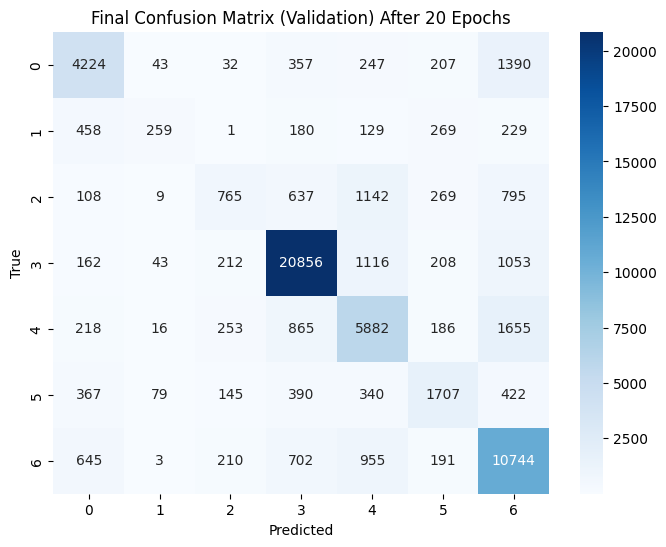

In [8]:
# Confusion matrix
final_cm = confusion_matrix(cumulative_labels, cumulative_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(final_cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(7), yticklabels=range(7))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Final Confusion Matrix (Validation) After 20 Epochs')
plt.show()


In [9]:
torch.save(model, '0_25_70.pth')